In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.model_build import *
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = 500
T = 1000
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


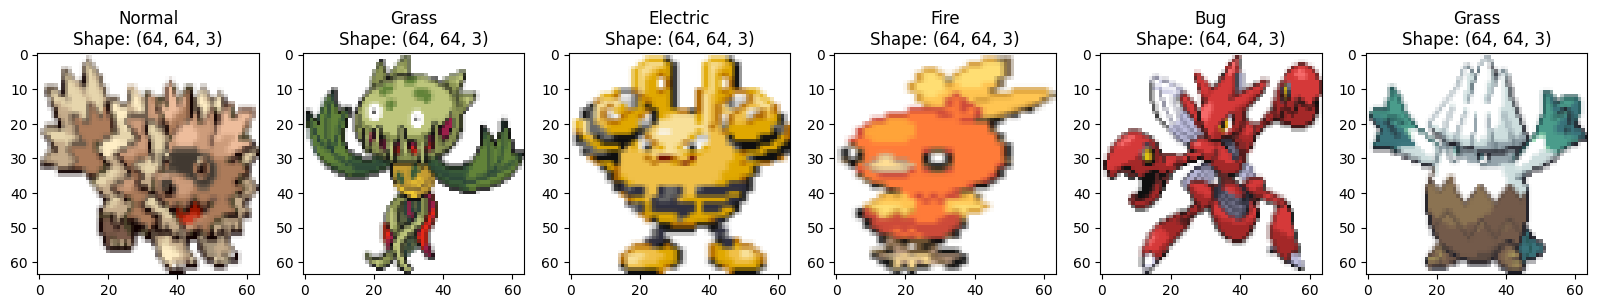

In [4]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    save=False,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [5]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES, num_channels=128, embedding_dim=128)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/500


I0000 00:00:1715272865.427271    7069 service.cc:145] XLA service 0x78f380002c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715272865.427294    7069 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1715272866.001626    7069 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1715272868.031277    7194 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6896', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1715272868.278081    7191 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6896', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1715272869.534813    7185 asm_compiler.cc:369] ptxas war

127/127 ━━━━━━━━━━━━━━━━━━━━ 86s 328ms/step - loss: 0.5909
Epoch 2/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - loss: 0.1676
Epoch 3/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 0.1577
Epoch 4/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 0.1627
Epoch 5/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 0.1207
Epoch 6/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 0.1012
Epoch 7/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - loss: 0.1045
Epoch 8/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - loss: 0.1303
Epoch 9/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - loss: 0.1158
Epoch 10/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.1089
Epoch 11/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 0.0766
Epoch 12/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 338ms/step - loss: 0.1314
Epoch 13/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 338ms/step - loss: 0.0908
Epoch 14/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0966
Epoch 15/500


Sampling sprite: 1000it [01:00, 16.61it/s]                        


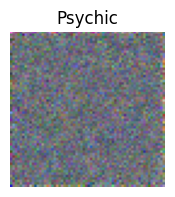

127/127 ━━━━━━━━━━━━━━━━━━━━ 103s 815ms/step - loss: 0.1105
Epoch 21/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.1237
Epoch 22/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0883
Epoch 23/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.1195
Epoch 24/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0910
Epoch 25/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - loss: 0.1013
Epoch 26/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0889
Epoch 27/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0799
Epoch 28/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 334ms/step - loss: 0.0534
Epoch 29/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0874
Epoch 30/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 337ms/step - loss: 0.0869
Epoch 31/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0561
Epoch 32/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - loss: 0.0664
Epoch 33/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.1017
Epoc

Sampling sprite: 1000it [00:58, 17.07it/s]                        


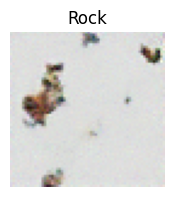

127/127 ━━━━━━━━━━━━━━━━━━━━ 102s 803ms/step - loss: 0.0532
Epoch 41/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.0674
Epoch 42/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.1083
Epoch 43/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - loss: 0.0594
Epoch 44/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0609
Epoch 45/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0570
Epoch 46/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - loss: 0.0833
Epoch 47/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0630
Epoch 48/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0626
Epoch 49/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0710
Epoch 50/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0855
Epoch 51/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 336ms/step - loss: 0.0587
Epoch 52/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 336ms/step - loss: 0.0675
Epoch 53/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0653
Epoc

Sampling sprite: 1000it [00:58, 17.04it/s]                        


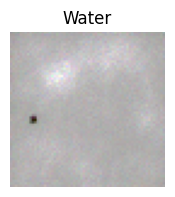

127/127 ━━━━━━━━━━━━━━━━━━━━ 102s 803ms/step - loss: 0.0779
Epoch 61/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.0514
Epoch 62/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 328ms/step - loss: 0.0572
Epoch 63/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0611
Epoch 64/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - loss: 0.0702
Epoch 65/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 0.0661
Epoch 66/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - loss: 0.0855
Epoch 67/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0702
Epoch 68/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - loss: 0.0595
Epoch 69/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0736
Epoch 70/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0733
Epoch 71/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0594
Epoch 72/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0730
Epoch 73/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0624
Epoc

Sampling sprite: 1000it [00:59, 16.95it/s]                        


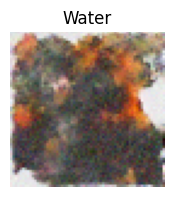

127/127 ━━━━━━━━━━━━━━━━━━━━ 102s 806ms/step - loss: 0.0485
Epoch 81/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.0717
Epoch 82/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0881
Epoch 83/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - loss: 0.0573
Epoch 84/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0615
Epoch 85/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - loss: 0.0664
Epoch 86/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - loss: 0.0470
Epoch 87/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 336ms/step - loss: 0.0627
Epoch 88/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 334ms/step - loss: 0.0447
Epoch 89/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 45s 357ms/step - loss: 0.0512
Epoch 90/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 341ms/step - loss: 0.0572
Epoch 91/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 341ms/step - loss: 0.0659
Epoch 92/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 339ms/step - loss: 0.0660
Epoch 93/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 44s 345ms/step - loss: 0.0751
Epoc

Sampling sprite: 1000it [00:58, 17.01it/s]                        


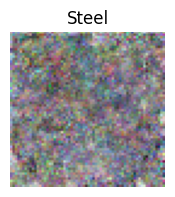

127/127 ━━━━━━━━━━━━━━━━━━━━ 102s 806ms/step - loss: 0.0477
Epoch 101/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - loss: 0.0487
Epoch 102/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - loss: 0.0629
Epoch 103/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - loss: 0.0646
Epoch 104/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.0635
Epoch 105/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - loss: 0.0551
Epoch 106/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - loss: 0.0526
Epoch 107/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 0.0716
Epoch 108/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0457
Epoch 109/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - loss: 0.0512
Epoch 110/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0501
Epoch 111/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0469
Epoch 112/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0818
Epoch 113/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss

Sampling sprite: 1000it [01:00, 16.60it/s]                        


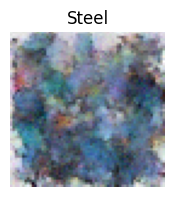

127/127 ━━━━━━━━━━━━━━━━━━━━ 103s 811ms/step - loss: 0.0602
Epoch 121/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0357
Epoch 122/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0610
Epoch 123/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0622
Epoch 124/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0466
Epoch 125/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 322ms/step - loss: 0.0607
Epoch 126/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 325ms/step - loss: 0.0570
Epoch 127/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - loss: 0.0521
Epoch 128/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 325ms/step - loss: 0.0402
Epoch 129/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0392
Epoch 130/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 328ms/step - loss: 0.0498
Epoch 131/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 337ms/step - loss: 0.0437
Epoch 132/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 334ms/step - loss: 0.0447
Epoch 133/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss

Sampling sprite: 1000it [00:59, 16.74it/s]                        


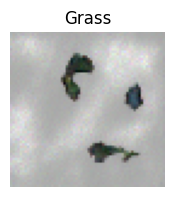

127/127 ━━━━━━━━━━━━━━━━━━━━ 102s 803ms/step - loss: 0.0507
Epoch 141/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0409
Epoch 142/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 323ms/step - loss: 0.0560
Epoch 143/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 323ms/step - loss: 0.0587
Epoch 144/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0476
Epoch 145/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0556
Epoch 146/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0522
Epoch 147/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0553
Epoch 148/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0608
Epoch 149/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0484
Epoch 150/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 326ms/step - loss: 0.0379
Epoch 151/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0508
Epoch 152/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 0.0614
Epoch 153/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 338ms/step - loss

Sampling sprite: 1000it [01:01, 16.36it/s]                        


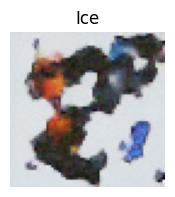

127/127 ━━━━━━━━━━━━━━━━━━━━ 103s 814ms/step - loss: 0.0489
Epoch 161/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 323ms/step - loss: 0.0762
Epoch 162/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 326ms/step - loss: 0.0490
Epoch 163/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.0390
Epoch 164/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 328ms/step - loss: 0.0650
Epoch 165/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 328ms/step - loss: 0.0601
Epoch 166/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.0504
Epoch 167/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 328ms/step - loss: 0.0536
Epoch 168/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - loss: 0.0450
Epoch 169/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 0.0522
Epoch 170/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0397
Epoch 171/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0446
Epoch 172/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 0.0476
Epoch 173/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss

Sampling sprite: 1000it [00:55, 18.18it/s]                        


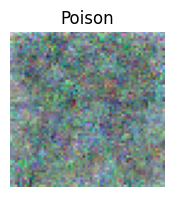

127/127 ━━━━━━━━━━━━━━━━━━━━ 96s 762ms/step - loss: 0.0923
Epoch 181/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0557
Epoch 182/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0613
Epoch 183/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0513
Epoch 184/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0371
Epoch 185/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0349
Epoch 186/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0454
Epoch 187/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0620
Epoch 188/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0441
Epoch 189/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0647
Epoch 190/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0557
Epoch 191/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0472
Epoch 192/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0363
Epoch 193/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss:

Sampling sprite: 1000it [00:53, 18.66it/s]                        


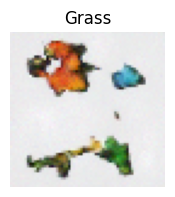

127/127 ━━━━━━━━━━━━━━━━━━━━ 95s 749ms/step - loss: 0.0356
Epoch 201/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0435
Epoch 202/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0712
Epoch 203/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0555
Epoch 204/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0367
Epoch 205/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0447
Epoch 206/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0641
Epoch 207/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0507
Epoch 208/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0483
Epoch 209/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0430
Epoch 210/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0459
Epoch 211/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0441
Epoch 212/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0625
Epoch 213/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss:

Sampling sprite: 1000it [00:53, 18.67it/s]                        


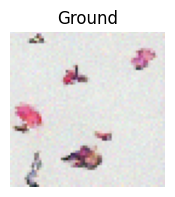

127/127 ━━━━━━━━━━━━━━━━━━━━ 95s 749ms/step - loss: 0.0676
Epoch 221/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0674
Epoch 222/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0482
Epoch 223/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0614
Epoch 224/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0378
Epoch 225/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0539
Epoch 226/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0526
Epoch 227/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0413
Epoch 228/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0462
Epoch 229/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0536
Epoch 230/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0533
Epoch 231/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0480
Epoch 232/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0450
Epoch 233/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss:

Sampling sprite: 1000it [00:53, 18.60it/s]                        


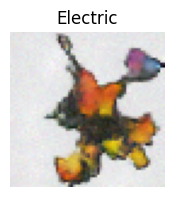

127/127 ━━━━━━━━━━━━━━━━━━━━ 95s 751ms/step - loss: 0.0412
Epoch 241/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0507
Epoch 242/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0379
Epoch 243/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0428
Epoch 244/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0486
Epoch 245/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0413
Epoch 246/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0606
Epoch 247/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0493
Epoch 248/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0456
Epoch 249/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0602
Epoch 250/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0654
Epoch 251/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0579
Epoch 252/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0458
Epoch 253/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss:

Sampling sprite: 1000it [00:53, 18.55it/s]                        


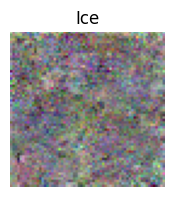

127/127 ━━━━━━━━━━━━━━━━━━━━ 95s 752ms/step - loss: 0.0565
Epoch 261/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0568
Epoch 262/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0531
Epoch 263/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0332
Epoch 264/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0532
Epoch 265/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0433
Epoch 266/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0493
Epoch 267/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0524
Epoch 268/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0586
Epoch 269/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0565
Epoch 270/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0566
Epoch 271/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0419
Epoch 272/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0576
Epoch 273/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss:

Sampling sprite: 1000it [00:54, 18.23it/s]                        


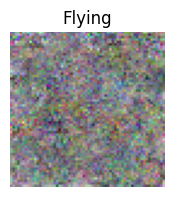

127/127 ━━━━━━━━━━━━━━━━━━━━ 96s 759ms/step - loss: 0.0415
Epoch 281/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 317ms/step - loss: 0.0425
Epoch 282/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 318ms/step - loss: 0.0508
Epoch 283/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0644
Epoch 284/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0362
Epoch 285/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0465
Epoch 286/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0507
Epoch 287/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 322ms/step - loss: 0.0415
Epoch 288/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0617
Epoch 289/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0405
Epoch 290/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0509
Epoch 291/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0365
Epoch 292/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 314ms/step - loss: 0.0496
Epoch 293/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss:

Sampling sprite: 1000it [00:54, 18.46it/s]                        


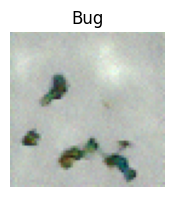

127/127 ━━━━━━━━━━━━━━━━━━━━ 95s 754ms/step - loss: 0.0659
Epoch 301/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0658
Epoch 302/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0545
Epoch 303/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0475
Epoch 304/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0390
Epoch 305/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0446
Epoch 306/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0413
Epoch 307/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0718
Epoch 308/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0413
Epoch 309/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0355
Epoch 310/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0426
Epoch 311/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0351
Epoch 312/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0622
Epoch 313/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss:

Sampling sprite: 1000it [00:55, 18.17it/s]                        


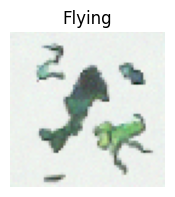

127/127 ━━━━━━━━━━━━━━━━━━━━ 96s 761ms/step - loss: 0.0454
Epoch 321/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0471
Epoch 322/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0535
Epoch 323/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0393
Epoch 324/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0474
Epoch 325/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0462
Epoch 326/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0610
Epoch 327/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0388
Epoch 328/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0632
Epoch 329/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0476
Epoch 330/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0565
Epoch 331/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0472
Epoch 332/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0427
Epoch 333/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss:

Sampling sprite: 1000it [00:54, 18.37it/s]                        


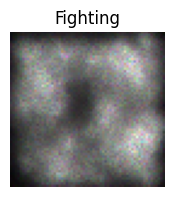

127/127 ━━━━━━━━━━━━━━━━━━━━ 96s 756ms/step - loss: 0.0417
Epoch 341/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0500
Epoch 342/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0373
Epoch 343/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0563
Epoch 344/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0399
Epoch 345/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0474
Epoch 346/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0504
Epoch 347/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0366
Epoch 348/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0484
Epoch 349/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0582
Epoch 350/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0251
Epoch 351/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0550
Epoch 352/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0490
Epoch 353/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss:

Sampling sprite: 1000it [00:54, 18.24it/s]                        


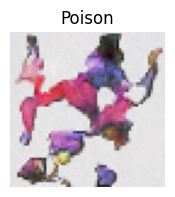

127/127 ━━━━━━━━━━━━━━━━━━━━ 96s 759ms/step - loss: 0.0477
Epoch 361/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0462
Epoch 362/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0362
Epoch 363/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0295
Epoch 364/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0400
Epoch 365/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0416
Epoch 366/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0582
Epoch 367/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0373
Epoch 368/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0419
Epoch 369/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0416
Epoch 370/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0438
Epoch 371/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0373
Epoch 372/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0386
Epoch 373/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss:

Sampling sprite: 1000it [00:56, 17.85it/s]                        


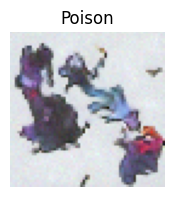

127/127 ━━━━━━━━━━━━━━━━━━━━ 97s 769ms/step - loss: 0.0400
Epoch 381/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0422
Epoch 382/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0485
Epoch 383/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0520
Epoch 384/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 50s 394ms/step - loss: 0.0675
Epoch 385/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 497ms/step - loss: 0.0557
Epoch 386/500
 73/127 ━━━━━━━━━━━━━━━━━━━━ 23s 442ms/step - loss: 0.0540

In [6]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=600, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
model.plot_samples(6, "Fire")
model.plot_samples(6, "Water")
model.plot_samples(6, "Grass")
model.plot_samples(6, "Flying")

In [ ]:
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)

In [ ]:
model.fit(poke_dataset, epochs=400, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
model.plot_samples(6, "Fire")
model.plot_samples(6, "Water")
model.plot_samples(6, "Grass")
model.plot_samples(6, "Flying")

In [ ]:
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [ ]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "../../models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.keras"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [ ]:
# Save the model
SCHEDULER = "linear"
EPOCHS = 1100
model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{SCHEDULER}_ddpm_attention_time_sin"

save_model(model, model_name)

/home/pqlza/.local/lib/python3.11/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


Model diffusion_32_64_1100_500_linear_ddpm_attention_time_sin, saved successfully!


In [ ]:
# load the model
# =====================================================================
model_loaded = tf.keras.models.load_model(f"../../models/{model_name}.keras")

model_load.plot_samples(6)

TypeError: <class 'src.model.overfitting_test.DiffusionModel'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'src.model.overfitting_test', 'class_name': 'DiffusionModel', 'config': {'trainable': True, 'dtype': 'float32'}, 'registered_name': 'DiffusionModel', 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 9.999999747378752e-05, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'MeanSquaredError', 'config': {'name': 'mean_squared_error', 'reduction': 'sum_over_batch_size'}, 'registered_name': None}, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class 'src.model.overfitting_test.DiffusionModel'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of DiffusionModel from its config.

Received config={'trainable': True, 'dtype': 'float32'}

Error encountered during deserialization: DiffusionModel.__init__() got an unexpected keyword argument 'trainable'

[BACK TO TOP](#top)